In [1]:
using DrWatson
@quickactivate "haram"

In [2]:
using main
using Plots, Random, Distributions, ProgressMeter
using Flux, DynamicPPL, Zygote, ForwardDiff

gr()
theme(:default)
default(fmt=:png, levels=100, lw=0.5, msw=0.5, la=0.5)
ProgressMeter.ijulia_behavior(:clear);

In [3]:
function plt(m=model(2), exts=[(-50, 50), (-30, 30)], len=500, cls=palette(:linear_wcmr_100_45_c42_n256, 100); levels=10)
    return contourf(
        range(exts[1]..., length=len),
        range(exts[2]..., length=len),
        # (x, y) -> m.f([x; y])^(1-1e-10), c=cls,
        (x, y) -> -(m.U([x; y])), c=cls,
        fa=0.25,
        levels=levels
    )
end

function make_colorbar(m, lims; len=500)
    z = map(
        (x, y) -> -(m.U([x; y])),
        range(lims[1]..., length=len),
        range(lims[2]..., length=len)
    ) |> extrema

    cls = palette(:linear_wcmr_100_45_c42_n256, 100)
    scatter(
        [0, 0], [0, 1], c=cls,
        zcolor=[0, 3], clims=z, 
        xlims=(1, 1.1), label="", cbartitle="",
        xshowaxis=false, yshowaxis=false, grid=false
    )
end

function scatterplot(x, baseplt=nothing; kwargs...)
    if !isnothing(baseplt)
        p = plot(baseplt)
    else
        p = plot(x -> 0, 0.01, 0.02, la=0, lw=0, c=:white)
    end
    p = plot(p, Tuple.(eachrow(x)); c=:black, lw=0.1, la=0.5, label="")
    p = scatter(p, Tuple.(eachrow(x)); c=:orange, kwargs...)
end

scatterplot (generic function with 2 methods)

In [4]:
@model function funnel(d, c=20.0)
    μ = 20
    σ = 5.0
    y ~ MixtureModel([Normal(-μ, σ), Normal(μ, σ)])
    x ~ MixtureModel([MvNormal(x_ * ones(d - 1), 1 * exp(sign(x_) * 0.5 * (y + x_))) for x_ in [-c, +c]])
end

function model(d=2; c=20.0)
    ℓ(x) = logjoint(funnel(d, c), (; x=x[1:end-1], y=x[end]))
    U(x) = isfinite(ℓ(x)) ? -ℓ(x) : 1e200
    dU(x) = ForwardDiff.gradient(U, x)
    f(x) = max(exp(-U(x)), 1e-200)
    g(x) = ForwardDiff.gradient(f, x)
    return main.Model(ξ=mod, d=d, f=f, g=g, U=U, dU=dU)
end

model (generic function with 2 methods)

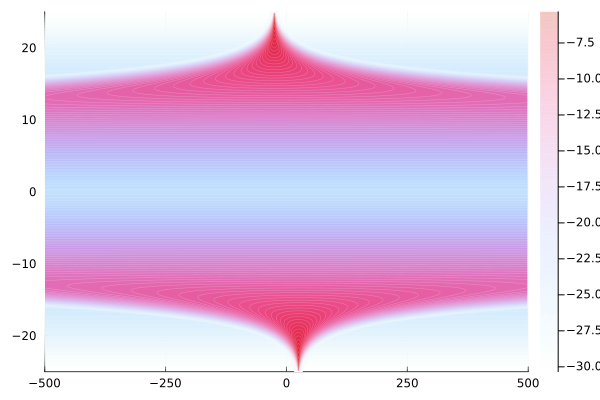

In [5]:
m = model(c=25.0)
exts = [(-500, 500), (-25, 25)]
plt(m, exts, levels=100)

Progress: 100%|█████████████████████████████████████████| Time: 0:01:28
  HaRAM(0.05, 200, 0.2, Any[]):  0.39771685692858927


Acceptance Ratio = 0.4055
 89.333384 seconds (528.72 M allocations: 26.668 GiB, 6.21% gc time, 8.03% compilation time: 1% of which was recompilation)


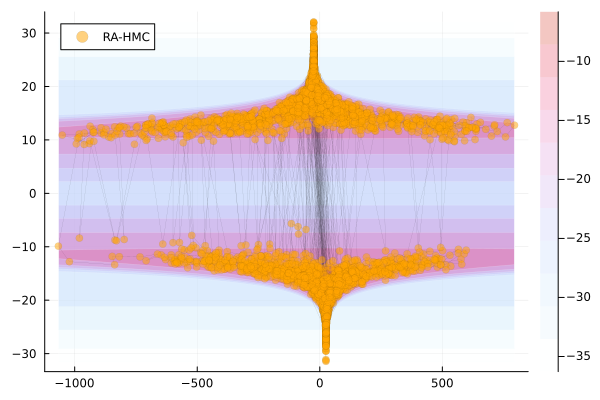

In [6]:
@time s1, a1 = mcmc(
    HaRAM(ϵ=0.05, L=200, γ=0.2),
    m; n=1e4, n_burn=2e3
)

x_haram = s1[a1, :]
lims = extrema.(eachcol(x_haram))

scatterplot(
    x_haram,
    plt(m, lims, levels=10);
    msw=0.1, ma=0.5, label="RA-HMC"
)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:11
  HMC(0.6, 50, Any[]):  0.7123573035580368


Acceptance Ratio = 0.7034


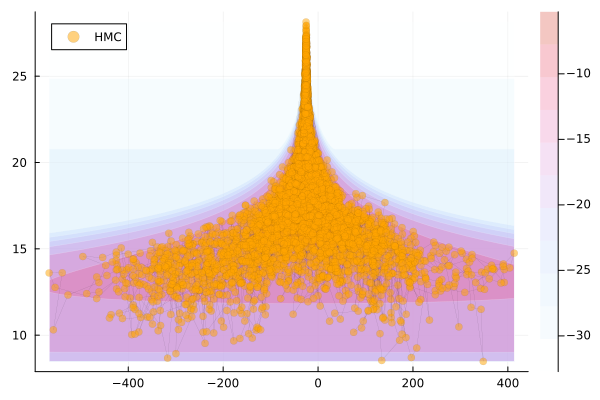

In [7]:
s2, a2 = mcmc(
    main.HMC(ϵ=0.6, L=50),
    m; n=1e4, n_burn=2e3
)
x_hmc = s2[a2, :]
lims = extrema.(eachcol(x_hmc))

scatterplot(
    x_hmc,
    plt(m, lims, levels=10);
    msw=0.1, ma=0.5, label="HMC"
)

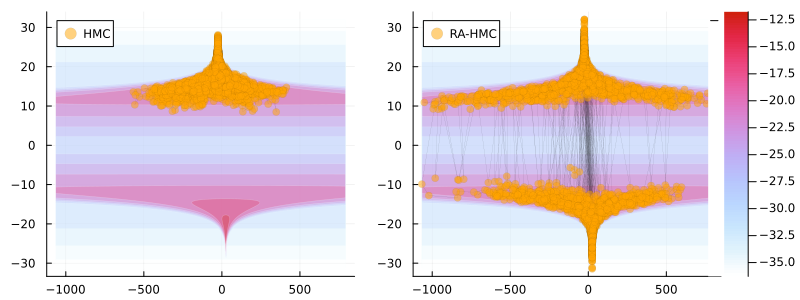

GKS: Rectangle definition is invalid in routine SET_VIEWPORT


In [8]:
lims = extrema.(eachcol([x_haram; x_hmc]))
baseplt = plt(m, lims, levels=10)
pars = (; msw=0.1, ma=0.5, colorbar=false)

p2 = scatterplot(x_haram, baseplt; label="RA-HMC", pars...)
p1 = scatterplot(x_hmc, baseplt; label="HMC", pars...)
h = make_colorbar(m, lims)

l = @layout [grid(1, 2) a{0.01w}]
plot(p1, p2, h, layout=l, size=(800, 300))

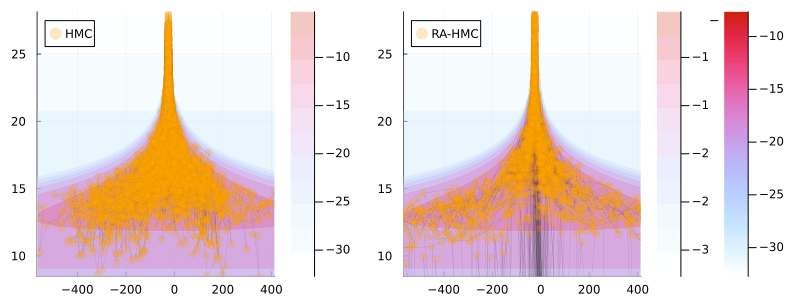

GKS: Rectangle definition is invalid in routine SET_VIEWPORT


In [9]:
lims = extrema.(eachcol(x_hmc))

zoom_plt1 = scatterplot(
    x_hmc,
    plt(m, lims, levels=10);
    msw=0.1, ma=0.25, label="HMC",
    xlim = lims[1], ylim=lims[2]
)

zoom_plt2 = scatterplot(
    x_haram,
    plt(m, lims, levels=10);
    msw=0.1, ma=0.25, label="RA-HMC",
    xlim = lims[1], ylim=lims[2]
)

h = make_colorbar(m, lims)

l = @layout [grid(1, 2) a{0.01w}]
plot(zoom_plt1, zoom_plt2, h, layout=l, size=(800, 300))